In [1]:
import warnings
warnings.filterwarnings("ignore")
import hcp_utils as hcp
import pandas as pd
import numpy as np
import nibabel as nib
from brainspace.utils.parcellation import map_to_labels
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from brainspace.gradient import GradientMaps
from brainspace import mesh
from brainspace.gradient.alignment import procrustes
import scipy.stats as ss
import sklearn.linear_model as sl
import statsmodels.api as sm
from matplotlib.patches import Rectangle
import func_plot as fp
import func_stats as fs

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


# BigBrain <- Cytoarchitecture

## Layer-specific asymmetry

In [2]:
# read surface mesh to plot data on the mesh
surf_lh = mesh.mesh_io.read_surface('../bigbrain/tpl-bigbrain_hemi-L_desc-mid_sym.surf.gii')
surf_rh = mesh.mesh_io.read_surface('../bigbrain/tpl-bigbrain_hemi-R_desc-mid_sym.surf.gii')

In [3]:
# read glasser atlas
glasser_l = nib.load('../bigbrain/tpl-bigbrain_hemi-L_desc-MMP.label.gii').agg_data()
glasser_r = nib.load('../bigbrain/tpl-bigbrain_hemi-R_desc-MMP.label.gii').agg_data()
glasser_r = glasser_r + 180
glasser_r[glasser_r==180]=0
glasser = np.concatenate((glasser_l, glasser_r))
mask = glasser != 0

In [4]:
# cortical thickness in each layer
thick1 = np.loadtxt('../bigbrain/thickness/tpl-bigbrain_hemi-L_desc-layer1_thickness.txt', delimiter=',')
thick2 = np.loadtxt('../bigbrain/thickness/tpl-bigbrain_hemi-L_desc-layer2_thickness.txt', delimiter=',')
thick3 = np.loadtxt('../bigbrain/thickness/tpl-bigbrain_hemi-L_desc-layer3_thickness.txt', delimiter=',')
thick4 = np.loadtxt('../bigbrain/thickness/tpl-bigbrain_hemi-L_desc-layer4_thickness.txt', delimiter=',')
thick5 = np.loadtxt('../bigbrain/thickness/tpl-bigbrain_hemi-L_desc-layer5_thickness.txt', delimiter=',')
thick6 = np.loadtxt('../bigbrain/thickness/tpl-bigbrain_hemi-L_desc-layer6_thickness.txt', delimiter=',')

In [5]:
thick1.mean(), thick2.mean(), thick3.mean(), thick4.mean(), thick5.mean(), thick6.mean()

(0.24396141518979703,
 0.2112458144857547,
 0.5713890035576099,
 0.18326657898719065,
 0.40763554596573265,
 0.4984149480209353)

In [6]:
# (left + right)/2 stands for the mean thickness for each region
thick = [thick1, thick2, thick3, thick4, thick5, thick6]
thick_par = np.zeros((6,180))
for i in range(6):
  for n in range(180): 
    thick_par[i][n] = (np.nanmean(thick[i][glasser[:163842]==n+1]) + np.nanmean(thick[i][glasser[163842:]==n+181]))/2
thick_par.shape

(6, 180)

In [7]:
# points: distance from the pial
points = np.zeros((6,180,10))
for i in range(6):
  for n in range(180):  
    points[i][n][:] = np.linspace(start=0, stop=thick_par[i][n], num=11)[1:]
    
for i in range(5):
  for n in range(10):
    points[i+1][:,n] = points[i+1][:,n] + points[i][:,9]

points = np.vstack((points[0].T,points[1].T,points[2].T,points[3].T,points[4].T,points[5].T))
points.shape

(60, 180)

In [8]:
# read density data
density = [None] * 6 # 6 layers, 10 surfaces for each layer
for i in range(6):
  layer_l = np.load('../bigbrain/density_profiles/density_profile_hemi-left_layer-'+str(i+1)+'_nsurf-10.npz')['profiles']
  layer_r = np.load('../bigbrain/density_profiles/density_profile_hemi-right_layer-'+str(i+1)+'_nsurf-10.npz')['profiles']
  density[i] = np.concatenate((layer_l,layer_r),axis=1)
density = np.vstack((density))
density.shape

(60, 327684)

In [9]:
# Calculate the mean intensity for 60 surfaces, summerized into MMP-Glasser parcellation
intensity = np.zeros((60,360))
for i in range(60):
  for n in range(360): 
    intensity[i][n] = np.nanmean(density[i][glasser==n+1])

transform = np.empty(intensity.shape)
for j in range(60):
    y=intensity[:,:180].mean(axis=0)
    x=sm.add_constant(intensity[j][:180])
    model = sm.OLS(y,x).fit() 
    transform[j][:180] = model.get_influence().resid_studentized_internal
    y=intensity[:,180:].mean(axis=0)
    x=sm.add_constant(intensity[j][180:])
    model = sm.OLS(y,x).fit() 
    tmp = model.get_influence().resid_studentized_internal
    transform[j][180:] = tmp
    
intensity = -transform.copy()
intensity[:,180:] = procrustes(intensity[:,180:], intensity[:,:180])

mp_lh_mean = np.zeros(60)
mp_rh_mean = np.zeros(60)
for i in range (60):
  mp_lh_mean[i] = np.mean(intensity[i][:180])
  mp_rh_mean[i] = np.mean(intensity[i][180:])

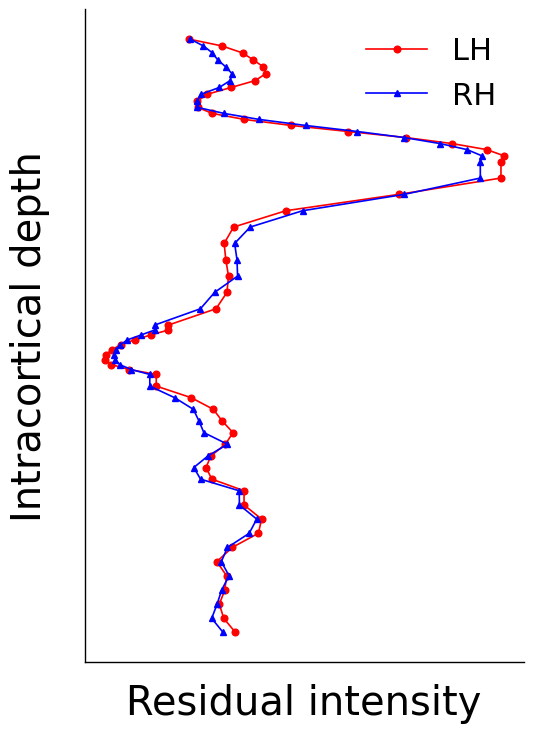

In [10]:
sns.set_context("paper", font_scale = 3)
fig = plt.figure(figsize=(6,8))
ax = fig.add_subplot(111)
ax.plot(mp_lh_mean, [-points[i].mean() for i in range(60)], c='r', marker = 'o', label='LH')
ax.plot(mp_rh_mean, [-points[i].mean() for i in range(60)], c='b', marker = '^', label='RH')
ax.set_ylabel('Intracortical depth', labelpad=25)
ax.set_xlabel('Residual intensity', labelpad=15)
ax.set_xticks([])
ax.set_yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(loc='upper right', fontsize=22, frameon=False)
plt.tight_layout()
plt.savefig('../figures/bigbrain/bigbrain_mean_intensity_profile.png', dpi=300, transparent=True)

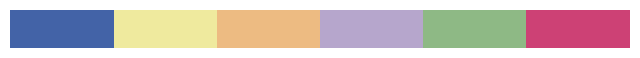

In [11]:
colordis = [thick[0].mean()*100,thick[0].mean()*100,thick[0].mean()*100,
            thick[0].mean()*100,thick[0].mean()*100,thick[0].mean()*100]
colordis = np.array(colordis).astype(int)
color_layer = [['#4363A7'] * colordis[0], ['#EFEA9E'] * colordis[1], ['#EDBB82'] * colordis[2],
               ['#B6A6CC'] * colordis[3], ['#8EB985'] * colordis[4], ['#CD4175'] * colordis[5]]
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
fig = plt.figure(figsize=(8,0.5))
ax = fig.add_subplot(111)
ax.imshow(gradient, aspect='auto', cmap=ListedColormap(np.concatenate((color_layer))))
ax.set_axis_off()
fig.savefig('../figures/bigbrain/bigbrain_layer_color_bin.png', dpi=300, transparent=True)     

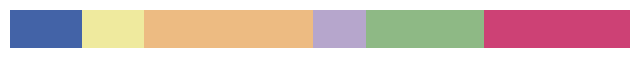

In [12]:
# plotting the layer color
colordis = [thick[0].mean()*100,thick[1].mean()*100,thick[2].mean()*100,
            thick[3].mean()*100,thick[4].mean()*100,thick[5].mean()*100]
colordis = np.array(colordis).astype(int)
color_layer = [['#4363A7'] * colordis[0], ['#EFEA9E'] * colordis[1], ['#EDBB82'] * colordis[2],
               ['#B6A6CC'] * colordis[3], ['#8EB985'] * colordis[4], ['#CD4175'] * colordis[5]]
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
fig = plt.figure(figsize=(8,0.5))
ax = fig.add_subplot(111)
ax.imshow(gradient, aspect='auto', cmap=ListedColormap(np.concatenate((color_layer))))
ax.set_axis_off()
fig.savefig('../figures/bigbrain/bigbrain_layer_color.png', dpi=300, transparent=True)  

In [13]:
np.savetxt('../bigbrain/bigbrain_LH_mean.txt', intensity.mean(axis=0)[:180])
np.savetxt('../bigbrain/bigbrain_RH_mean.txt', intensity.mean(axis=0)[180:])
plot = map_to_labels(intensity.mean(axis=0), glasser, mask=mask)
plot[plot==0]=np.nan

fp.plot_surface_lr(surf_lh, surf_rh, data = plot,
                   size = (1200, 200), color_range=(-1,1),
                   cmap = 'BuPu', filename = '../figures/bigbrain/bigbrain_intensity_layer.png')

In [14]:
plot = [None] * 6
 
for i in range(6):
    tmp = intensity[i*6:(i+1)*6].mean(axis=0)
    np.savetxt('../bigbrain/bigbrain_LH_layer_'+str(i+1)+'.txt', tmp[:180])
    np.savetxt('../bigbrain/bigbrain_RH_layer_'+str(i+1)+'.txt', tmp[180:])
    plot[i] = map_to_labels(tmp, glasser, mask=mask)
    plot[i][plot[i]==0]=np.nan

fp.plot_surface_lr(surf_lh, surf_rh, data = plot,
                   size = (1200, 1200), color_range=(-2,2),
                   cmap = 'BuPu', filename = '../figures/bigbrain/bigbrain_intensity_mean.png')

In [15]:
mp_asy = intensity[:,:180] - intensity[:,180:]
for i in range(6):
  np.savetxt('../bigbrain/bigbrain_asy_layer_'+str(i+1)+'.txt', mp_asy[i*10:(i+1)*10].mean(axis=0))

In [16]:
plot = [None] * 6
 
for i in range(6):
    plot[i] = map_to_labels(np.concatenate((mp_asy[i*10:(i+1)*10].mean(axis=0),np.zeros(180))), glasser, mask=mask)
    plot[i][plot[i]==0]=np.nan

fp.plot_surface_lr(surf_lh, surf_rh, data = plot,
                   size = (1200, 1200), color_range=(-0.3,0.3),
                   cmap = 'RdBu_r', filename = '../figures/bigbrain/bigbrain_mean_AI_layer.png')

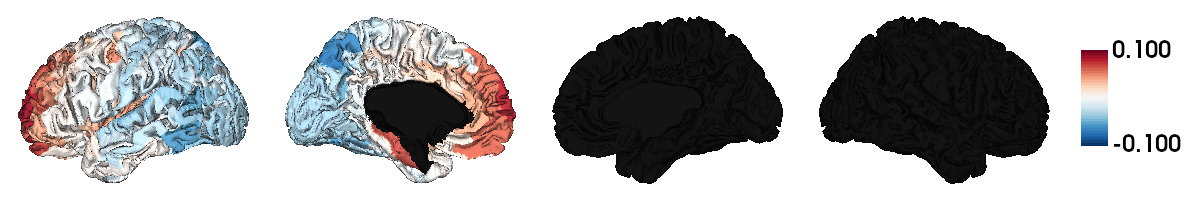

In [17]:
plot = map_to_labels(np.concatenate((mp_asy.mean(axis=0),np.zeros(180))), glasser, mask=mask)
plot[plot==0]=np.nan
np.savetxt('../bigbrain/bigbrain_asy_mean.txt', mp_asy.mean(axis=0))

fp.plot_surface_lr(surf_lh, surf_rh, data = plot,
                   size = (1200, 200), color_range=(-0.1,0.1),
                   cmap = 'RdBu_r', filename = '../figures/bigbrain/bigbrain_mean_AI_overall.png')

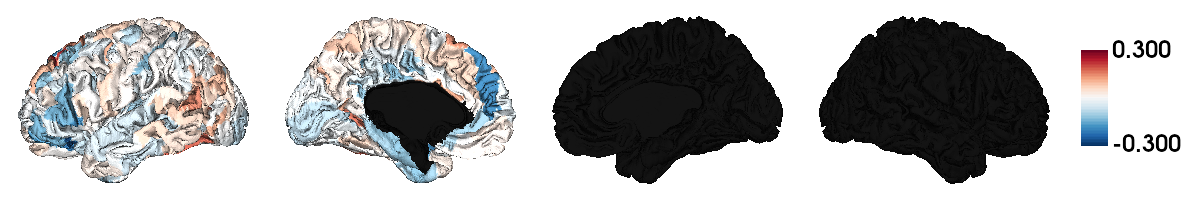

In [18]:
skewness = ss.skew(intensity, axis=0)
skew_asy = skewness[:180] - skewness[180:]
np.savetxt('../bigbrain/skewness_asy.txt', skew_asy)

plot = map_to_labels(np.concatenate((skew_asy,np.zeros(180))), glasser, mask=mask)
plot[plot==0]=np.nan

fp.plot_surface_lr(surf_lh, surf_rh, data = plot,
                   size = (1200, 200), color_range=(-0.3, 0.3),
                   cmap = 'RdBu_r', filename = '../figures/bigbrain/skew_asy.png')

In [19]:
plot = map_to_labels(skewness, glasser, mask=mask)
plot[plot==0]=np.nan

fp.plot_surface_lr(surf_lh, surf_rh, data = plot,
                   size = (1200, 200), color_range=(-1, 1),
                   cmap = 'spring', filename = '../figures/bigbrain/skewness.png')

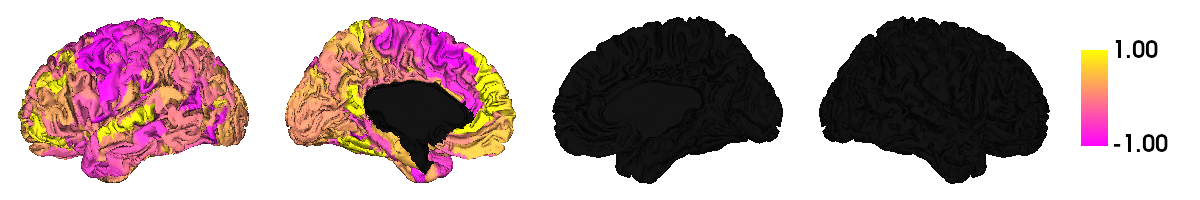

In [20]:
asy_skewness = ss.skew(mp_asy, axis=0)
np.savetxt('../bigbrain/asy_skewness.txt', asy_skewness)

plot = map_to_labels(np.concatenate((asy_skewness,np.zeros(180))), glasser, mask=mask)
plot[plot==0]=np.nan

fp.plot_surface_lr(surf_lh, surf_rh, data = plot,
                   size = (1200, 200), color_range=(-1, 1),
                   cmap = 'spring', filename = '../figures/bigbrain/asy_skewness.png')

In [21]:
mp_asy_layer = np.zeros((6,180))
for i in range(6):
    mp_asy_layer[i] = mp_asy[i*6:(i+1)*6].mean(axis=0)
np.corrcoef(mp_asy_layer), np.corrcoef(mp_asy_layer).mean(axis=0)

(array([[ 1.        ,  0.15359733, -0.47119647,  0.16024605, -0.24345497,
         -0.06763907],
        [ 0.15359733,  1.        ,  0.27246586,  0.23097303,  0.10501234,
         -0.15518289],
        [-0.47119647,  0.27246586,  1.        , -0.23827353,  0.19234504,
          0.55254257],
        [ 0.16024605,  0.23097303, -0.23827353,  1.        ,  0.23529477,
          0.11130018],
        [-0.24345497,  0.10501234,  0.19234504,  0.23529477,  1.        ,
          0.23208898],
        [-0.06763907, -0.15518289,  0.55254257,  0.11130018,  0.23208898,
          1.        ]]),
 array([0.08859215, 0.26781094, 0.21798058, 0.24992342, 0.25354769,
        0.27885163]))

### Plot the 12 networks on BigBrain space

In [22]:
ca = np.array(pd.read_csv('../data/ca_glasser_network.csv', header = None))[:,0]
cmap = ListedColormap(np.vstack((list(hcp.ca_network['rgba'].values())))[1:])
color = ca[:180]

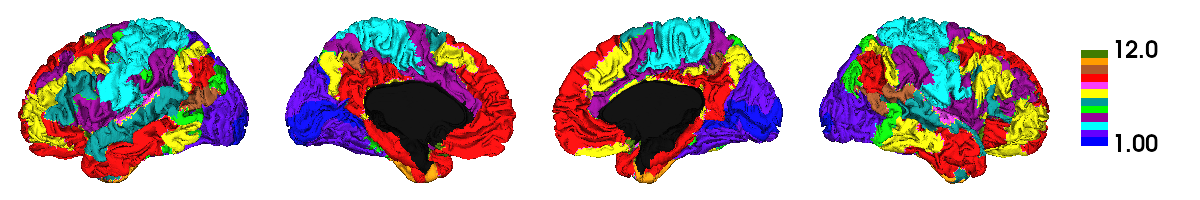

In [23]:
ca_64 = map_to_labels(ca, glasser, mask=mask)
ca_64[ca_64==0]=np.nan

fp.plot_surface_lr(surf_lh, surf_rh, data = ca_64.astype(float),
                  size = (1200, 200), color_range=(1,12),
                  cmap = cmap, filename = '../figures/bigbrain/bigbrain_ca_atlas.png')

In [24]:
ca_lh = np.zeros((60,12))
ca_rh = np.zeros((60,12))
for i in range(60):
  for n in range(12):
    ca_lh[i,n] = np.mean(intensity[i,:180][ca[:180]==n+1])
    ca_rh[i,n] = np.mean(intensity[i,180:][ca[180:]==n+1])

In [25]:
points_ca = np.zeros((60,12))
for i in range(60):
    for n in range(12):
        points_ca[i][n] = points[i][ca[:180]==n+1].mean()

In [26]:
ca_asy = ca_lh - ca_rh
a = []
for i in range(12):
  a.append(ss.pearsonr(ca_asy[:,i], points_ca[:,i]))
df = pd.DataFrame(np.vstack((fp.network_name, np.array(a).T, fs.fdr(np.array(a)[:,1]))).T)
df.columns = ['CA_label', 'perason_r', 'p', 'p_fdr']
df.style.set_caption("asymetry VS thickness")

In [27]:
ca_asy.shape

(60, 12)

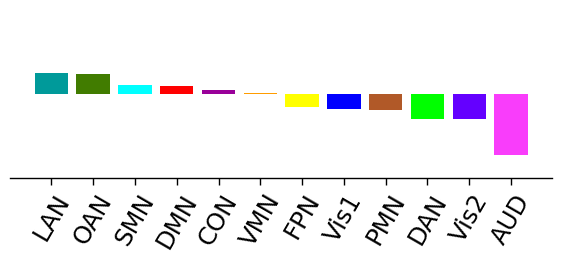

In [28]:
sns.set_context("paper", font_scale = 2)
fig, ax = plt.subplots(figsize=(6,3))
fp.plot_t_single(ca_asy.mean(axis=0), ax = ax, x_rota=60, bar=None, thres=0.1, ascend=False)
np.savetxt('../bigbrain/ca_asy_mean.txt', ca_asy.mean(axis=0))
fig.tight_layout()
fig.savefig('../figures/bigbrain/bigbrain_ca_overall_rank.png', dpi=300, transparent=True)

In [29]:
# plotting the rank color
plot = ca_asy.mean(axis=0).argsort().reshape(1,12)
plot = np.insert(plot,[1,2,3,4,5,6,7,8,9,10,11], [-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1],axis=1)
fig = plt.figure(figsize=(12,0.5))
ax = fig.add_subplot(111)
ax.imshow(plot, aspect='auto', cmap=fp.cmap_ca_white)
ax.set_axis_off()
fig.savefig('../figures/bigbrain/bigbrain_ca_overall_rank_color.png', dpi=300, transparent=True)   

In [30]:
rank = ca_asy.mean(axis=0).argsort()
plot = ca_asy[:,rank]
df=pd.DataFrame()
matrix = np.arange(0, 720).reshape((12, 60)) % 60
df['x'] = matrix.T.flatten()
matrix = np.arange(0, 720).reshape((12, 60)) % 12
df['y'] = matrix.flatten()
df['color'] = plot.flatten()
df['size'] = abs(plot).flatten()
sns.relplot(data=df, x='x', y='y',hue='color', size='size', palette='RdBu_r',
            sizes=(40, 400), linewidth=0, legend=False,
            hue_norm=(-0.3, 0.3), size_norm=(0, 0.3),
            aspect=5, height=4)
plt.axis('off')
plt.tight_layout()
plt.savefig('../figures/bigbrain/bigbrain_ca_intensity_asy_heatmap.png', dpi=300, transparent=True)

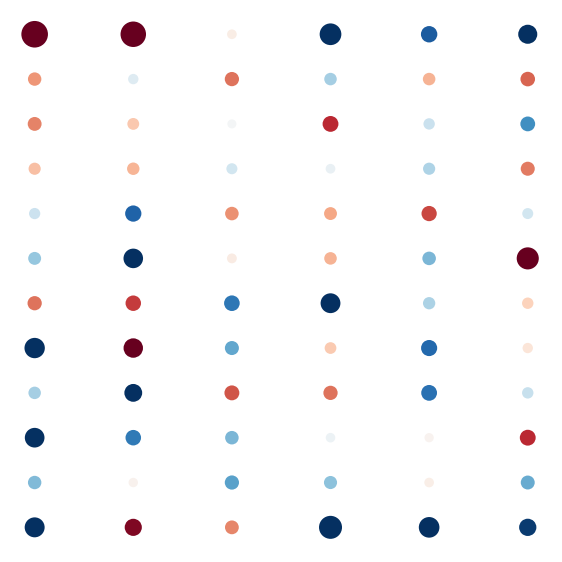

In [31]:
ca_asy_layer = np.zeros((6,12))
for i in range(6):
  ca_asy_layer[i] = ca_asy[i*10:(i+1)*10].mean(axis=0)
np.savetxt('../bigbrain/ca_asy_layer.txt',ca_asy_layer.T)
plot = ca_asy_layer[:,rank]
df=pd.DataFrame()
matrix = np.arange(0, 72).reshape((12, 6)) % 6
df['x'] = matrix.T.flatten()
matrix = np.arange(0, 72).reshape((12, 6)) % 12
df['y'] = matrix.flatten()
df['color'] = plot.flatten()
df['size'] = abs(plot).flatten()
#df['size'] = np.array([colordis] * 12).T.flatten()
sns.relplot(data=df, x='x', y='y',hue='color', size='size', palette='RdBu_r',
            sizes=(40, 400), linewidth=0, legend=False, 
            hue_norm=(-0.1, 0.1), size_norm=(0, 0.3),
            aspect=1, height=6)
plt.axis('off')
plt.tight_layout()
plt.savefig('../figures/bigbrain/bigbrain_ca_intensity_asy_layer_heatmap.png', dpi=300, transparent=True)

In [32]:
layer_skew = ss.skew(ca_asy,axis=0)
layer_skew

array([-0.08059342,  0.07578463, -0.42053256, -0.33902219,  0.50677671,
        0.25999756, -0.39389848,  0.69000206,  0.14230049,  0.20802706,
        0.27034065,  0.18046855])

In [33]:
sns.set_context("paper", font_scale = 2)
fig, ax = plt.subplots(figsize=(6,3))
fp.plot_t_single(layer_skew, ax = ax, x_rota=60, bar=None, thres=1, ascend=False)
fig.tight_layout()
fig.savefig('../figures/bigbrain/bigbrain_ca_asy_skewness_rank.png', dpi=300, transparent=True)

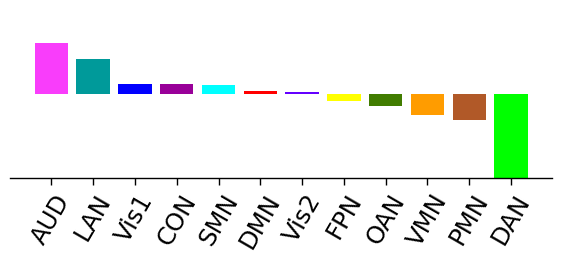

In [34]:
skew_asy = ss.skew(ca_lh,axis=0) - ss.skew(ca_rh,axis=0) 
sns.set_context("paper", font_scale = 2)
fig, ax = plt.subplots(figsize=(6,3))
fp.plot_t_single(skew_asy, ax = ax, x_rota=60, bar=None, thres=0.3, ascend=False)
fig.tight_layout()
fig.savefig('../figures/bigbrain/bigbrain_ca_skewness_asy_rank.png', dpi=300, transparent=True)